### Unused P infinity paragraph

The conductivity of the entire lattice would only depend on the number of occupied sites in the spanning cluster. Any finite cluster would not help in conducting current through the entire lattice. Therefore it is important to know the term P$\infty$ which is the proportion of occupied sites in the infinite grid, to total occupied sites. It is also known that there is a power law relation between the conductivity of such a lattice and the proportion of occupied sites relative to the percolation threshold [3].


 &   P\infty = \text{(Occupied sites in infinite cluster)/(occupied sites)}\\
 


In [3]:
import random

In [4]:
# Get random co-ordinates in Python

j = 1
while j < 5:  # loop to print lots of co-ordinates at once
    x = random.randrange(0,10)
    y = random.randrange(0,10)

    print("Co-ordinates of site %i  = ( %i, %i)" % (j,x,y) )
    j += 1

# (0, 0) is the bottom left corner of the bottom leftmost square.
# (9, 9) is the bottom left corner of the top rightmost square.

Co-ordinates of site 1  = ( 1, 1)
Co-ordinates of site 2  = ( 1, 0)
Co-ordinates of site 3  = ( 6, 4)
Co-ordinates of site 4  = ( 5, 9)


In [5]:
# If coordinates are repeated use this to get a new random coordinate

x = random.randrange(0,10)
y = random.randrange(0,10)

print("Co-ordinates  = ( %.f, %.f)" % (x,y) )

Co-ordinates  = ( 4, 5)


In [6]:
# Written by Marin Soreng 2004

# MK_EQSYSTEM sets up Kirchoff's equations for the 2 D lattice.
# Lattice has X * Y rows and 2 columns . The rows indicate the site ,
# the first column the bond perpendicular to the flow direction
# and the second column the bond parallel to the flow direction .

# The return values are [B , C ] where B * x = C . This is solved
# for the site pressure by x = B \ C .

def MK_EQSYSTEM (Lattice , X , Y ):

    # Total no of internal lattice sites
    sites = X *( Y - 2)
    
    # Allocate space for the nonzero upper diagonals
    main_diag = zeros(sites)
    upper_diag1 = zeros(sites - 1)
    upper_diag2 = zeros(sites - X)
    
    # Calculates the nonzero upper diagonals
    main_diag = Lattice[X:X*(Y-1), 0] + Lattice[X:X*(Y-1), 1] + \
                Lattice[0:X*(Y-2), 1] + Lattice[X-1:X*(Y-1)-1, 0]
    upper_diag1 = Lattice [X:X*(Y-1)-1, 0]
    upper_diag2 = Lattice [X:X*(Y-2), 1]
    main_diag[where(main_diag == 0)] = 1
    # Constructing B which is symmetric , lower = upper diagonals .
    B = dia_matrix ((sites , sites)) # B *u = t
    B = - spdiags ( upper_diag1 , -1 , sites , sites )
    B = B + - spdiags ( upper_diag2 ,-X , sites , sites )
    B = B + B.T + spdiags ( main_diag , 0 , sites , sites )
    # Constructing C
    C = zeros(sites)
    # C = dia_matrix ( (sites , 1) )
    C[0:X] = Lattice[0:X, 1]
    C[-1-X+1:-1] = 0*Lattice [-1 -2*X + 1:-1-X, 1]
    return B , C


In [7]:
# Written by Marin Soreng 2004

# FIND_COND calculates the effective conductance of the lattice.
# FIND_COND also calculates the potential V for every site.
def FIND_COND (Lattice , X , Y ):
    V_in = 1.
    V_out = 0.
    # Calls MK_EQSYSTEM .
    B,C = MK_EQSYSTEM (Lattice , X , Y )
    
    # Kirchhoff ’ s equations solve for V
    V = spsolve(B, C)
    
    # The pressure at the external sites is added
    # ( Boundary conditions )
    V = concatenate((V_in * ones (X), V, V_out * ones (X)))
    
    # Calculate Ceff
    # second-last X elements of V multiplied with second-last elem. of A
    # these are the second last column of the system
    # gives the conductivity of the system per row
    Ceff = dot((V[-1-2*X:-1-X] - V_out).T, Lattice[-1-2*X:-1-X, 1]) \
    / ( V_in - V_out )
    return V , Ceff


In [8]:
# Written by Marin Soreng 2004

# sitetobond turns the percolation matrix z into a bond matrix.
# Bond percolation is a simpler system to solve

def sitetobond ( z ):
    # Function to convert the site network z(L,L) into a (L*L,2) bond network
    # L is the length of a side of the square lattice
    # g [i,0] gives bond perpendicular to direction of flow
    # g [i,1] gives bond parallel to direction of flow
    # z [ nx , ny ] -> g [ nx * ny , 2]
    nx = size (z ,1 - 1)
    ny = size (z ,2 - 1)
    N = nx * ny
    gg_r = zeros ((nx , ny)) # First , find these
    gg_d = zeros ((nx , ny )) # First , find these
    gg_r [:, 0:ny - 1] = z [:, 0:ny - 1] * z [:, 1:ny]
    gg_r [: , ny - 1] = z [: , ny - 1]
    gg_d [0:nx - 1, :] = z [0:nx - 1, :] * z [1:nx, :]
    gg_d [nx - 1, :] = 0
    
    # Then , concatenate gg onto g
    g = zeros ((nx *ny ,2))
    g [:, 0] = gg_d.reshape(-1,order="F").T
    g [:, 1] = gg_r.reshape(-1,order="F").T
    return g


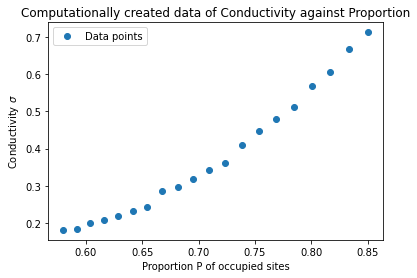

In [45]:
# Creating a numerical lattice of size 10x10 and finding conductivity
## as random sites are taken out of the lattice.

from pylab import *
from scipy.ndimage import measurements
from matplotlib.colors import ListedColormap
from pylab import *
from scipy.sparse import spdiags, dia_matrix, coo_matrix
from scipy.sparse.linalg import spsolve


Lvals = [10] # The size of the lattice is 10 x 10
pVals = logspace(log10(0.58), log10(0.85), 20) # proportion values
C = zeros((len(pVals),len(Lvals)),float)
P = zeros((len(pVals),len(Lvals)),float)
nSamples = 600
mu = zeros(len(Lvals))

L = Lvals[0]
lx = L         # width of square lattice
ly = L         # height of one side of square lattice
for pIndex in range(len(pVals)):
    p = pVals[pIndex]
    ncount = 0
    for j in range(nSamples):
        ncount = 0
        perc = []
        while (len(perc)==0):
            ncount = ncount + 1
            if (ncount > 1000):
                print("Couldn’t make percolation cluster...")
                break
            z=rand(L,L)<p
            lw,num = measurements.label(z) # Labelling each cluster z
            
            # Check if the set of clusters on the left side and 
            ## the set on the right side have any intersection.
            perc_x = intersect1d(lw[0,:],lw[-1,:]) 
            perc = perc_x[where(perc_x > 0)]
            
            #If the length of the set of intersections is larger than zero, 
            ##there is at least one percolating cluster:
        if len(perc) > 0:
            zz = asarray((lw == perc[0])) # array of True or false terms.
            # zz now contains the spanning cluster
                
            zzz = zz.T # Extracts zz values that are "True"
                
            # # Generate bond lattice from this
            g = sitetobond ( zzz )
                
            # # Generate conductivity matrix using FIND_COND
            Pvec, c_eff = FIND_COND(g, lx, ly)
            C[pIndex,0] = C[pIndex,0] + c_eff
    C[pIndex,0] = C[pIndex,0]/nSamples

#Plotting the values of conductivity versus proportion P.

L = Lvals[0]
plot(pVals,C[:,0],  "o", label="Data points")
plt.title("Computationally created data of Conductivity against Proportion")
xlabel("Proportion P of occupied sites")
ylabel("Conductivity $\sigma$ ")
plt.savefig("Malthegraph1.png", dpi=100)
legend()



[2.17360724 0.86554752]
[[0.00329429 0.00294705]
 [0.00294705 0.00276704]]


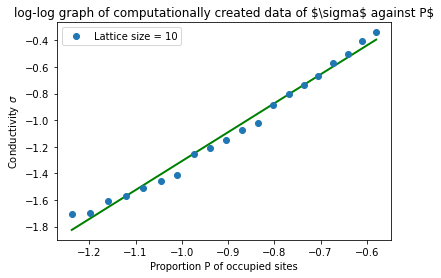

In [46]:
# Creating log-log graph with numerically obtained values.
# Finding numerical value of critical exponent t from the slope.

# Line of best fit
pars, cov = curve_fit(fitfunc, np.log(pVals-0.29),  np.log(C[:,0]))
plt.plot(np.log(pVals-0.29), fitfunc(np.log(pVals-0.29),*pars), 'g-', linewidth = '2')

print(pars)
print(cov)



L = Lvals[0]
plot(np.log(pVals-0.29), np.log(C[:,0]),  "o", label="Lattice size = 10")
plt.title("log-log graph of computationally created data of $\sigma$ against P$")

xlabel("Proportion P of occupied sites")
ylabel("Conductivity $\sigma$ ")
plt.savefig("Malthegraphlog1.png", dpi=100)

legend()



In [ ]:
# Copy pasted code from Oslo University percolation book
from pylab import *
from scipy.ndimage import measurements
nsamp = 2000
L = 200
p = 0.58
allarea = array([])
for i in range(nsamp):
    z = rand(L)
    m = z<p
    lw, num = measurements.label(m)
    labelList = arange(lw.max() + 1)
    area = measurements.sum(m, lw, labelList)
    allarea = append(allarea,area)

n,sbins = histogram(allarea,bins=int(max(allarea)))
s = 0.5*(sbins[1:]+sbins[:-1])
nsp = n/(L*nsamp)
i = nonzero(n)

subplot(2,1,1)
plot(s[i],nsp[i],"o")
xlabel("$s$")
ylabel("$n(s,p)$")

subplot(2,1,2)
loglog(s[i],nsp[i],"o")
xlabel("$s$")
ylabel("$n(s,p)$")

0.5877979797979798


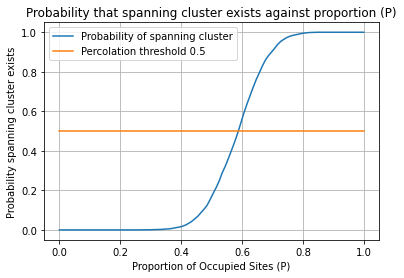

In [15]:
# Percolation threshold numerical calculation

# This code creates a graph of the probability that a spanning cluster is 
## present versus the proportion P for a 2D lattice of known size LL.

from pylab import *
from scipy.ndimage import measurements

# Defining the 2D lattice as being 10x10 squares big
LL = [10]

p = linspace(0,1,100) # Defining all proportion values

nL = len(LL)
nx = len(p)
Ni = zeros((nx,nL),float)
Pi = zeros((nx,nL),float)

for element in range(nL):
    L = LL[element]
    N = int(2000*25/L)
    for i in range(N):
        z = rand(L,L)
        for ip in range(nx):
            m = z<p[ip]
            lw, num = measurements.label(m)
            perc_x = intersect1d(lw[0,:],lw[-1,:])
            perc = perc_x[where(perc_x>0)]
            if (len(perc)>0):
                Ni[ip,element] = Ni[ip,element] + 1
    Pi[:,element] = Ni[:,element]/N
    
    # Finding Pc which equals the P value that gives 
    ##probability of spanning cluster of 0.5 .
    # interp Prints the x value that gives y = 0.5
    print(np.interp(0.5,Pi[:,element],p)) 
    
    

    # Creating graph
for element in range(nL):
    L = LL[element]
    lab = "$L="+str(L)+"$"
    plot(p,Pi[:,element],label=lab)
    ylabel("Probability spanning cluster exists")
    xlabel("Proportion of Occupied Sites (P)")
    plt.title("Probability that spanning cluster exists against proportion (P)")
    plt.grid(True) 




# Plotting the line that intersects the curve at the point (Pc, 0.5)
plt.plot([0,1],[0.5,0.5])  

legend(["Probability of spanning cluster","Percolation threshold 0.5"])
plt.savefig("spanning_cluster_graph.png", dpi=100)

In [34]:
# Percolation threshold numerical calculation for 2-d lattice.

# Code Developed by Anders Malthe-Sorensson, University of Oslo

# This code creates a graph of the probability that a spanning cluster is 
## present versus the proportion P for a 2D lattice of known size LL.

from pylab import *
from scipy.ndimage import measurements

# Defining the 2D lattice as being 10x10 squares big
LL = 10

p = linspace(0,1,100) # Defining all proportion values

nx = len(p)
Ni = zeros((nx,1),float)

# Pi will become the Probabilities that a spanning cluster exists
Pi = zeros((nx,1),float) 

for element in range(1):
    N = int(2000*25/LL)
    for i in range(N):
        z = rand(LL,LL)     # Random site coordinate in lattice
        for ip in range(nx):
            m = z<p[ip]
            lw, num = measurements.label(m)
            perc_x = intersect1d(lw[0,:],lw[-1,:]) # Testing using intersect
            perc = perc_x[where(perc_x>0)]
            if (len(perc)>0):
                Ni[ip,element] = Ni[ip,element] + 1
    Pi[:,element] = Ni[:,element]/N
    
    # Finding Pc which equals the P value that gives Probability of spanning cluster of 0.5
    print(np.interp(0.5,Pi[:,element],p)) # This Prints the x value that gives y = 0.5
    
    

 # Creating graph
for element in range(1):
    lab = "$L="+str(LL)+"$"
    plot(p,Pi[:,element],label=lab)
    ylabel("Probability spanning cluster exists")
    xlabel("Proportion of Occupied Sites (P)")
    plt.title("Probability that spanning cluster exists against proportion (P)")
    plt.grid(True) 




# Plotting the line that intersects the curve at the point (Pc, 0.5)
plt.plot([0,1],[0.5,0.5])  

legend(["Probability of spanning cluster","Percolation threshold 0.5"])
plt.savefig("spanning_cluster_graph.png", dpi=100)

KeyboardInterrupt: 

In [35]:
print(range(1))

range(0, 1)


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
%matplotlib inline

## Data for 1st run of 2-D experiment

In [14]:
# Defining equation of line of best fit 
def fitfunc(x, m, c):
    return x*m+c

In [4]:
## Error analysis on Tin Foil run 1



[3.45433667 4.90399467]
[[ 0.0280117  -0.02268948]
 [-0.02268948  0.01873329]]


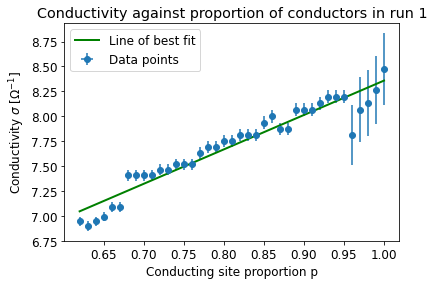

In [8]:
# Two-dimensional experiment run 1.
# Defining Conductivity = 1/(R)
Conductivity1 = np.array([1/.118, 1/.121, 1/.123, 1/.124, 1/.128, 
                          1/.122, 1/.122, 1/.122, 1/.123, 1/.124,
                          1/.124, 1/.124, 1/.127, 1/.127, 1/.125, 
                          1/.126, 1/.128, 1/.128, 1/.128, 1/.129,
                          1/.129, 1/.130, 1/.130, 1/.131, 1/.133, 
                          1/.133, 1/.133, 1/.134, 1/.134, 1/.135,
                          1/.135, 1/.135, 1/.135, 1/.141, 1/.141, 
                          1/.143, 1/.144, 1/.145, 1/.144])
# p1 = Proportion of occupied sites.
p1 = np.arange(1,.61,-.01)

# Defining errors
# Propogating 0.001 ohm error on R to conductivity per data point.
yerror1 = ()
j = 0
while j < len(Conductivity1):
    if j < 5: # For disturbances in the tin foil at the beginning
        yerror1 = np.append(yerror1, 
                           np.sqrt((Conductivity1[j]**2)**2*0.005**2))
    else:
        yerror1 = np.append(yerror1, 
                            np.sqrt((Conductivity1[j]**2)**2*0.001**2))
    j = j + 1

# No error on Proportion of occupied sites P
xerr1 = 0
# Plotting data points with error bars
plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['font.size'] = 12
plt.errorbar(p1, Conductivity1, yerror1, xerr1,
             fmt = 'o', label = 'mydata')

# Line of best fit
pars, cov = curve_fit(fitfunc, p1, Conductivity1)
plt.plot(p1, fitfunc(p1,*pars), 'g-', linewidth = '2')

print(pars)
print(cov)

# Creating graph
plt.title("Conductivity against proportion of conductors in run 1")
plt.xlabel("Conducting site proportion p")
plt.ylabel("Conductivity ""$\sigma$ [$\Omega ^{-1}$]")
plt.legend(["Line of best fit","Data points"])
plt.savefig('tinfoil_graph1.png', dpi=100)
plt.show()


##### It is worth noting that the conductivity gradually reduces very gradually until the infinite cluster is cut, as shown in the following graph where the conductivity of zero is included

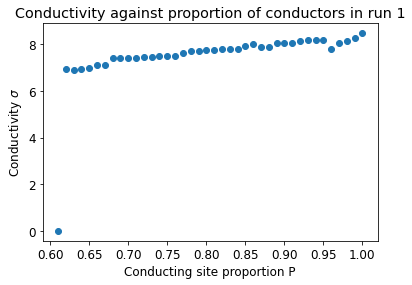

In [9]:
# Creating plot of conductivity against P with percolation threshold added

Conductivity1withzero = [1/.118, 1/.121, 1/.123, 1/.124, 1/.128,
                         1/.122, 1/.122, 1/.122, 1/.123, 1/.124,
                         1/.124, 1/.124, 1/.127, 1/.127, 1/.125, 
                         1/.126, 1/.128, 1/.128, 1/.128, 1/.129,
                         1/.129, 1/.130, 1/.130, 1/.131, 1/.133, 
                         1/.133, 1/.133, 1/.134, 1/.134, 1/.135,
                         1/.135, 1/.135, 1/.135, 1/.141, 1/.141, 
                         1/.143, 1/.144, 1/.145, 1/.144, 0]

# conducting site proportion p with p percolation threshold added.
p1withzero = np.arange(1,.60,-.01)

#Creating plot
plt.plot(p1withzero, Conductivity1withzero, "o")
plt.title("Conductivity against proportion of conductors in run 1")
plt.xlabel("Conducting site proportion P")
plt.ylabel("Conductivity ""$\sigma$")
plt.savefig('tinfoil_graph1withzero1.png', dpi=100)


[0.06374317 2.15613207]
[[1.06488489e-05 1.93884907e-05]
 [1.93884907e-05 4.20794304e-05]]


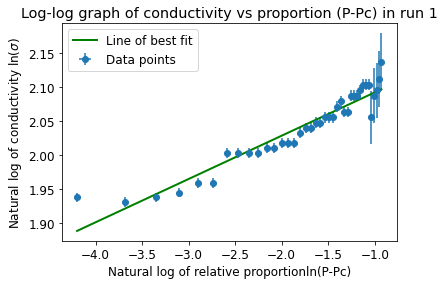

In [10]:
#Plotting log(conductivity) - log (P-Pc) plot for run 1
# Errors on log(conductivity)
yerrorlog1 = ()
j = 0
while j < len(Conductivity1):
    yerrorlog1 = np.append(yerrorlog1,
                           np.sqrt(((1/Conductivity1[j])**2*yerror1[j]**2)))
    j = j + 1
    
#plot
# Plotting data points with error bars
plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['font.size'] = 12
plt.errorbar(np.log(p1-.605), np.log(Conductivity1), 
             yerrorlog1, xerr1, fmt = 'o', label = 'mydata')

# Line of best fit
pars, cov = curve_fit(fitfunc, np.log(p1-.605),
                      np.log(Conductivity1))

plt.plot(np.log(p1-.605), fitfunc(np.log(p1-.605),*pars),
         'g-', linewidth = '2')

print(pars)
print(cov)

# Creating graph
plt.title("Log-log graph of conductivity vs proportion (P-Pc) in run 1")
plt.xlabel("Natural log of relative proportionln(P-Pc)")
plt.ylabel("Natural log of conductivity ln($\sigma$)")
plt.legend(["Line of best fit","Data points"])
plt.savefig('tinfoil_loggraph1.png', dpi=100)
plt.show()


This could be a result of the large size of the 2cm $\times$ 2cm sites compared to the 20cm $\times$ 20cm grid. The current would have had a large amount of tin foil to flow through even if only a single line of sites were in the infinite cluster. To achieve a more linear decrease towards zero, a grid of 0.5cm $\times$ 0.5cm squares would require further research.

## Data for 2nd run of 2-D experiment

[5.12931762 3.51339299]
[[ 0.03352903 -0.02699087]
 [-0.02699087  0.02217443]]


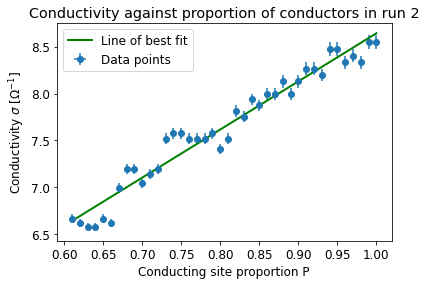

In [12]:
Conductivity2 = np.array([1/.117, 1/.117, 1/.120, 1/.119, 1/.120, 
                          1/.118, 1/.118, 1/.122, 1/.121, 1/.121,
                          1/.123, 1/.125, 1/.123, 1/.125, 1/.125,
                          1/.127, 1/.126, 1/.129, 1/.128, 1/.133, 
                          1/.135, 1/.132, 1/.133, 1/.133, 1/.133, 
                          1/.132, 1/.132, 1/.133, 1/.139, 1/.140,
                          1/.142, 1/.139, 1/.139, 1/.143, 1/.151,
                          1/.150, 1/.152, 1/.152, 1/.151, 1/.150])

# conducting site proportion p is a list starting at 1 and going to .62
p2 = np.arange(1,.60,-.01)

#Error analysis on tin foil conductivity run 2
# Propogating 0.001 ohm error on resistance to conductivity per data point.
yerror2 = ()
j = 0
while j < len(Conductivity2):
    yerror2 = np.append(yerror2, np.sqrt(Conductivity2[j]**4*0.001**2))
    j = j + 1
# np.sqrt((Conductivity2[j])**4*0.001**2) is just the propagation formula.

# No error on Proportion of occupied sites P => xerr = 0
xerr = 0

# Plotting data points with error bars
plt.errorbar(p2, Conductivity2, yerror2, xerr,
             fmt = 'o', label = 'mydata')

# Line of best fit
pars, cov = curve_fit(fitfunc, p2, Conductivity2)
plt.plot(p2, fitfunc(p2,*pars), 'g-', linewidth = '2')

print(pars)
print(cov)

# Creating graph
plt.title("Conductivity against proportion of conductors in run 2")
plt.xlabel("Conducting site proportion P")
plt.ylabel("Conductivity ""$\sigma$ [$\Omega ^{-1}$]")
plt.legend(["Line of best fit","Data points"])
plt.savefig('tinfoil_graph2.png', dpi=100)

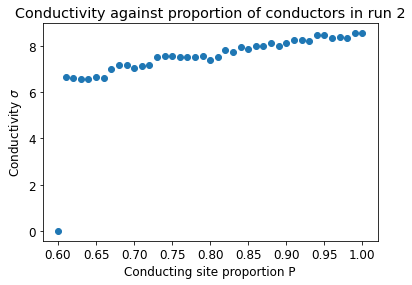

In [13]:
# Plotting 2-d experiment run 2 with (x,y) = (Pc,0) added

Conductivity2withzero = np.array([1/.117, 1/.117, 1/.120, 1/.119, 1/.120, 
                          1/.118, 1/.118, 1/.122, 1/.121, 1/.121,
                          1/.123, 1/.125, 1/.123, 1/.125, 1/.125,
                          1/.127, 1/.126, 1/.129, 1/.128, 1/.133, 
                          1/.135, 1/.132, 1/.133, 1/.133, 1/.133, 
                          1/.132, 1/.132, 1/.133, 1/.139, 1/.140,
                          1/.142, 1/.139, 1/.139, 1/.143, 1/.151,
                          1/.150, 1/.152, 1/.152, 1/.151, 1/.150, 0])

# conducting site proportion p with pc added
p2withzero = np.arange(1,.59,-.01)

#Creating plot
plt.plot(p2withzero, Conductivity2withzero, "o")
plt.title("Conductivity against proportion of conductors in run 2")
plt.xlabel("Conducting site proportion P")
plt.ylabel("Conductivity ""$\sigma$")
plt.savefig('tinfoil_graph1withzero1.png', dpi=100)


[0.07628634 2.17603807]
[[3.36680346e-05 6.42269091e-05]
 [6.42269091e-05 1.53343178e-04]]


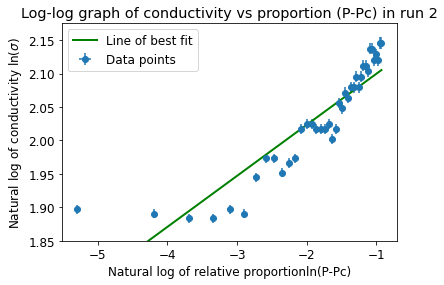

In [14]:
#Plotting log(conductivity) - log (P-Pc) plot for run 2
# Errors on log(conductivity) for Run 2
yerrorlog2 = ()
j = 0
while j < len(Conductivity2):
    yerrorlog2 = np.append(yerrorlog2, 
                           np.sqrt(((1/Conductivity2[j])**2*yerror2[j]**2)))
    j = j + 1

xerr2 = 0

#plot
# Plotting data points with error bars
plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['font.size'] = 12
plt.errorbar(np.log(p2-.605), np.log(Conductivity2), 
             yerrorlog2, xerr2, fmt = 'o', label = 'mydata')

# Line of best fit
pars, cov = curve_fit(fitfunc, np.log(p2-.605),
                      np.log(Conductivity2))

plt.plot(np.log(p2-.605), fitfunc(np.log(p2-.605),*pars),
         'g-', linewidth = '2')

print(pars)
print(cov)

# Creating graph
plt.title("Log-log graph of conductivity vs proportion (P-Pc) in run 2")
plt.xlabel("Natural log of relative proportionln(P-Pc)")
plt.ylabel("Natural log of conductivity ln($\sigma$)")
plt.ylim(1.85,2.175)
plt.legend(["Line of best fit","Data points"])
plt.savefig('tinfoil_loggraph2.png', dpi=100)
plt.show()


In [15]:

print(yerrorlog1-yerrorlog2)

ValueError: operands could not be broadcast together with shapes (39,) (40,) 

In these graphs it is noted that at high proportions (p) of conductive sites the relationship between p and $\sigma$ is linear. 

However, at values of p closer to pc the relationship is more eratic. Groups of data points at the same conductance level occur more frequently. This is a result of the removed sites being unimportant to the path the current takes as they are in dead ends of the infinite cluster, or even in finite clusters.

Large jumps in conductivity also occur more frequently as p decreases as weak links are cut.

# Try do the more detailed analysis of plotting log(sigma) against log(p-pc) or whatever is said in the simple percolation paper to find exponent t

<ipython-input-16-2511957b55cb>:3: RuntimeWarning: invalid value encountered in log
  logp_minus_pc1 = np.log(p1-59)


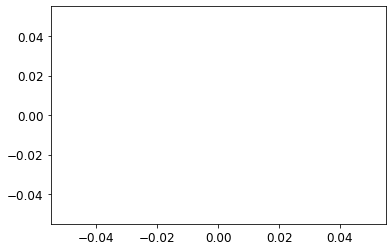

In [16]:
logconductivity1 = np.log(Conductivity1)

logp_minus_pc1 = np.log(p1-59) 


plt.plot(logp_minus_pc1,logconductivity1, "o")

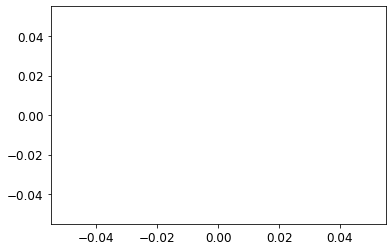

In [17]:
plt.plot(logp_minus_pc1,Conductivity1, "o")

# Three dimensional case

Area = $\Pi$ * ($\frac{diameter}{2}^2$)

Area = 4.67478x10^-3


$\sigma = \frac{L}{RA}$

In [35]:
# Unused python data
Rbefore = np.array([0.178*10**3, 0.261*10**3, 0.498*10**3, 0.543*10**3, 0.636*10**3, 0.126*10**3, 
             0.728*10**3, 1.628*10**3, 3.64*10**3, 5.25*10**3, 9.48*10**3, 5.89*10**3, 32.9*10**3,
              12.9*10**3, 42.2*10**3, 45.5*10**3, 55.8*10**3])

R = np.array([0.18*10**3, 0.26*10**3, 0.50*10**3, 0.54*10**3, 0.64*10**3, 0.13*10**3, 
             0.73*10**3, 1.63*10**3, 3.6*10**3, 5.3*10**3, 9.5*10**3, 5.9*10**3, 33*10**3,
              13*10**3, 42*10**3, 46*10**3, 56*10**3])

deltaR = np.array([0.1*10**3, 0.1*10**3, 0.1*10**3, 0.1*10**3, 0.1*10**3, 
                   0.1*10**3, 0.1*10**3, 1*10**3, 1*10**3, 1*10**3, 
                  1*10**3, 1*10**3, 10*10**3, 10*10**3, 10*10**3, 
                  10*10**3, 10*10**3])

deltaR1 = np.array([0.001*10**3, 0.001*10**3, 0.001*10**3, 0.001*10**3, 0.001*10**3, 
                   0.001*10**3, 0.001*10**3, 0.01*10**3, 0.01*10**3, 0.01*10**3, 
                  0.01*10**3, 0.01*10**3, 0.1*10**3, 0.1*10**3, 0.1*10**3, 
                  0.1*10**3, 0.1*10**3])


deltaR2 = np.array([0.01*10**3, 0.01*10**3, 0.01*10**3, 0.01*10**3, 0.01*10**3, 
                   0.01*10**3, 0.01*10**3, 0.1*10**3, 0.1*10**3, 0.1*10**3, 
                  0.1*10**3, 0.1*10**3, 1*10**3, 1*10**3, 1*10**3, 
                  1*10**3, 1*10**3])

In [3]:
#Proportions P of steel balls to total balls that data points were taken at
P = np.array([1, 0.94, 0.88, 0.82, 0.76, 0.70, 0.64, 
              0.58, 0.52, 0.49, 0.46, 0.43, 0.4, 0.37, 
              0.34, 0.31, 0.30])


R = np.array([0.2*10**3, 0.3*10**3, 0.5*10**3, 0.5*10**3, 0.6*10**3, 0.1*10**3, 
             0.7*10**3, 2*10**3, 4*10**3, 5*10**3, 10*10**3, 6*10**3, 30*10**3,
              10*10**3, 40*10**3, 50*10**3, 60*10**3])

# Values of L from P = 100% to P = 30%
L = np.array([0.111, 0.111, 0.109, 0.108, 0.107, 0.105, 0.104, 0.104, 
             0.098, 0.098, 0.097, 0.098, 0.96,  0.101, 0.097, 0.096, 
             0.095])

#Defining Surface Area of cylinder
A = np.pi * (0.07715/2)**2

# Calculating conductivity sigma
sigma = ()
i = 0
while i < len(R):
    sigma = np.append(sigma, L[i]/(R[i]*A))
    i += 1


In [8]:
# Error analysis on three dimensional experiment

# Error on surface area (A) of cylinder:
deltaA = 6.837*10**(-6)

# Error on length (L) of conductor:
deltaL = 0.0005

#Error on resistance:
deltaR = R * 0.5


# Propagating error onto conductivity:
deltaSigma = ()
j = 0
while j < len(deltaR):
    deltaSigma = np.append(deltaSigma, np.sqrt( ( L[j]/(R[j]**2*A) )**2 * deltaR[j]**2 + 
                                                ( 1/(R[j] * A) )**2* deltaL**2 + 
                                                ( L[j]/(R[j]*A**2) )**2 * deltaA**2 ) )
    j = j + 1
    


[0.05936101 0.039574   0.02331657 0.02310266 0.01907396 0.1123046
 0.01589072 0.00556175 0.00262044 0.00209635 0.00103748 0.00174696
 0.00342262 0.00108026 0.00025937 0.00020536 0.00016935]
[0.05936367 0.03957578 0.02331766 0.02310375 0.01907487 0.11231018
 0.01589152 0.00556203 0.00262059 0.00209647 0.00103754 0.00174706
 0.00342263 0.00108032 0.00025939 0.00020537 0.00016936]
[0.11872201 0.07914801 0.04663315 0.04620532 0.03814791 0.22460921
 0.03178144 0.0111235  0.00524088 0.00419271 0.00207496 0.00349392
 0.00684523 0.00216053 0.00051874 0.00041071 0.0003387 ]


<ErrorbarContainer object of 3 artists>

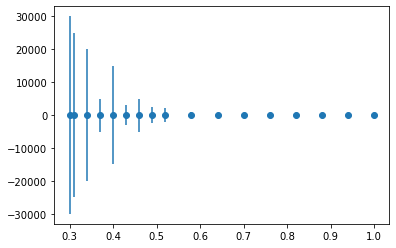

In [10]:
test = ()
j = 0
while j < len(deltaR):
    test = np.append(test, np.sqrt(( L[j]/(R[j]**2*A) )**2 * deltaR[j]**2 ))
    
    j += 1
print(test)
print(deltaSigma)
print(sigma)
xerror3D = 0
plt.errorbar(P, sigma, deltaR, xerror3D, fmt = 'o', label = 'mydata')


[ 0.15849126 -0.05610331]
[[ 0.0027099  -0.0015845 ]
 [-0.0015845   0.00105999]]


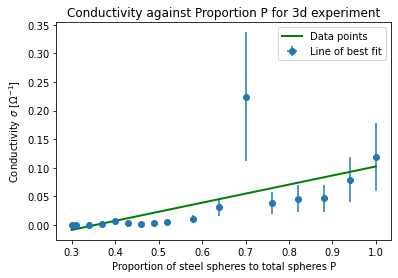

In [13]:
# Plot of Conductivity against P for 3 d experiment
xerror3D = 0

pars1, cov1 = curve_fit(fitfunc, P, sigma)
print(pars1)
print(cov1)

plt.errorbar(P, sigma, deltaSigma, xerror3D, fmt = 'o', label = 'mydata')
plt.plot(P, fitfunc(P,*pars1), 'g', linewidth = '2')

plt.xlabel("Proportion of steel spheres to total spheres P")
plt.ylabel("Conductivity $\sigma$ [$\Omega ^{-1}$]")
plt.title("Conductivity against Proportion P for 3d experiment")
plt.savefig("Conductivityversusp",dpi = 100)
plt.legend(["Data points","Line of best fit"])

[ 1.49999229 -2.18524168]
[[0.02960827 0.05039191]
 [0.05039191 0.12797176]]


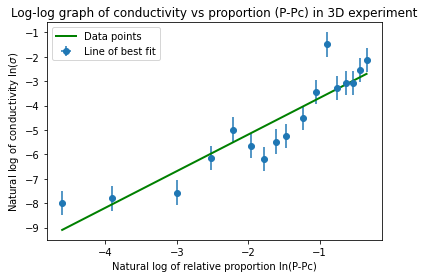

In [17]:
#Plotting log-log plot of 3-d experiment conductivity vs P-Pc

# Propagate deltaSigma onto log(sigma):
yerror3D = ()
j = 0
while j < len(deltaSigma):
    yerror3D = np.append(yerror3D, np.sqrt( ( 1/(sigma[j]) )**2 * (deltaSigma[j])**2 ))
    j = j + 1
    
# No error on Proportion of occupied sites P => xerr = 0
xerror3D = 0

# Creating Plot
pars1, cov1 = curve_fit(fitfunc, np.log(P-.29), np.log(sigma))
print(pars1)
print(cov1)

plt.errorbar(np.log(P-.29), np.log(sigma), yerror3D, xerror3D, fmt = 'o', label = 'mydata')
plt.plot(np.log(P-.29), fitfunc(np.log(P-.29),*pars1), 'g', linewidth = '2')

plt.xlabel("Natural log of relative proportion ln(P-Pc)")
plt.ylabel("Natural log of conductivity ln($\sigma$)")
plt.title("Log-log graph of conductivity vs proportion (P-Pc) in 3D experiment")
plt.savefig("log_log_conductivity",dpi = 100)
plt.legend(["Data points","Line of best fit"])

[ 0.13323727 -0.05212967]
[[ 2.51561179e-04 -1.45276582e-04]
 [-1.45276582e-04  9.68447656e-05]]


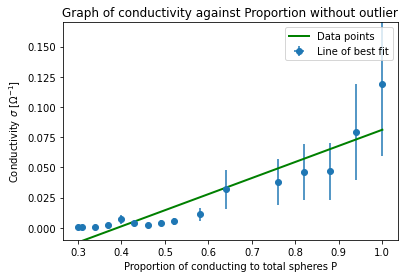

In [18]:

#removing outlier data

Psubset = np.array([1, 0.94, 0.88, 0.82, 0.76,0.64, 0.58, 0.52, 0.49, 0.46, 0.43, 0.4, 0.37, 0.34, 0.31, 0.30])


Rsubset = np.array([0.2*10**3, 0.3*10**3, 0.5*10**3, 0.5*10**3, 0.6*10**3,  
             0.7*10**3, 2*10**3, 4*10**3, 5*10**3, 10*10**3, 6*10**3, 30*10**3,
              10*10**3, 40*10**3, 50*10**3, 60*10**3])


# Values of L from P = 100% to P = 30%
Lsubset = np.array([0.111, 0.111, 0.109, 0.108, 0.107, 0.104, 0.104, 
             0.098, 0.098, 0.097, 0.098, 0.96,  0.101, 0.097, 0.096, 
             0.095])


# Calculating conductivity sigma
sigmasubset = ()
i = 0
while i < len(Rsubset):
    sigmasubset = np.append(sigmasubset, Lsubset[i]/(Rsubset[i]*A))
    i += 1

    
    #Errors
deltaRsubset = Rsubset * 0.5

# Propagating error onto conductivity:
deltaSigmasubset = ()
j = 0
while j < len(deltaRsubset):
    deltaSigmasubset = np.append(deltaSigmasubset, np.sqrt( ( Lsubset[j]/(Rsubset[j]**2*A) )**2 * deltaRsubset[j]**2 + 
                                                ( 1/(Rsubset[j] * A) )**2* deltaL**2 + 
                                                ( Lsubset[j]/(Rsubset[j]*A**2) )**2 * deltaA**2 ) )
    j = j + 1
    
    
# Plot of Conductivity against P for 3 d experiment
pars1, cov1 = curve_fit(fitfunc, Psubset, sigmasubset)
print(pars1)
print(cov1)

plt.errorbar(Psubset, sigmasubset, deltaSigmasubset, xerror3D, fmt = 'o', label = 'mydata')
plt.plot(Psubset, fitfunc(Psubset,*pars1), 'g', linewidth = '2')

plt.xlabel("Proportion of conducting to total spheres P")
plt.ylabel("Conductivity $\sigma$ [$\Omega ^{-1}$]")
plt.ylim(-.01,0.17)
plt.title("Graph of conductivity against Proportion without outlier")
plt.savefig("Python3dwithoutoutlier",dpi = 100, bbox_inches = "tight")
plt.legend(["Data points","Line of best fit"])

[ 1.42575809 -2.44217203]
[[0.01899192 0.03328526]
 [0.03328526 0.08627296]]


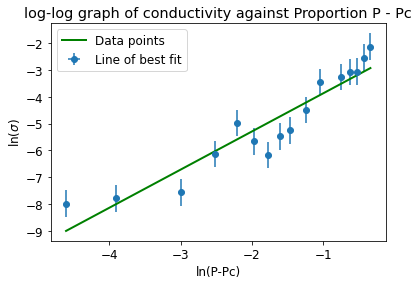

In [60]:
#Plotting log-log plot of 3-d experiment conductivity vs P-Pc
# Propagate deltaSigma onto log(sigma):
yerror3Dsubset = ()
j = 0
while j < len(deltaSigmasubset):
    yerror3Dsubset = np.append(yerror3Dsubset, 
                               np.sqrt( ( 1/(sigmasubset[j]) )**2 * (deltaSigmasubset[j])**2 ))
    j = j + 1
    
# No error on Proportion of occupied sites P => xerr = 0
xerror3Dsubset = 0


# Creating Plot
pars1, cov1 = curve_fit(fitfunc, np.log(Psubset-.29), np.log(sigmasubset))
print(pars1)
print(cov1)

plt.errorbar(np.log(Psubset-.29), np.log(sigmasubset),
             yerror3Dsubset, xerror3Dsubset, fmt = 'o', label = 'mydata')

plt.plot(np.log(Psubset-.29), 
         fitfunc(np.log(Psubset-.29),*pars1), 'g', linewidth = '2')

plt.xlabel("ln(P-Pc)")
plt.ylabel("ln($\sigma$)")
plt.title("log-log graph of conductivity against Proportion P - Pc")
plt.savefig("log_log_conductivity_without_outlier",dpi = 100)
plt.legend(["Data points","Line of best fit"])

# Error analysis on balls experiment

In [68]:
#checking error propagation stuff
i = 1
np.sqrt( ( 1/Lsubset[i]/(Rsubset[i]*A) )**2 * (deltaSigmasubset[i])**2 )

0.2542280648900584

[ 1.57793994 -2.09428951]
[[0.02660421 0.04088239]
 [0.04088239 0.08592529]]


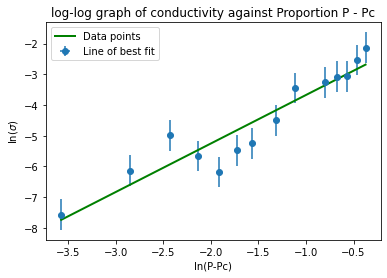

In [58]:
Psubset2 = np.array([1, 0.94, 0.88, 0.82, 0.76,0.64, 0.58, 0.52, 0.49, 0.46, 0.43, 0.4, 0.37, 0.34])


Rsubset2 = np.array([0.2*10**3, 0.3*10**3, 0.5*10**3, 0.5*10**3, 0.6*10**3,  
             0.7*10**3, 2*10**3, 4*10**3, 5*10**3, 10*10**3, 6*10**3, 30*10**3,
              10*10**3, 40*10**3])


# Values of L from P = 100% to P = 30%
Lsubset2 = np.array([0.111, 0.111, 0.109, 0.108, 0.107, 0.104, 0.104, 
             0.098, 0.098, 0.097, 0.098, 0.96,  0.101, 0.097])


# Calculating conductivity sigma
sigmasubset2 = ()
i = 0
while i < len(Rsubset2):
    sigmasubset2 = np.append(sigmasubset2, Lsubset2[i]/(Rsubset2[i]*A))
    i += 1

    #Errors
deltaRsubset2 = Rsubset2 * 0.5

# Propagating error onto conductivity:
deltaSigmasubset2 = ()
j = 0
while j < len(deltaRsubset2):
    deltaSigmasubset2 = np.append(deltaSigmasubset2, np.sqrt( ( Lsubset2[j]/(Rsubset2[j]**2*A) )**2 * deltaRsubset2[j]**2 + 
                                                ( 1/(Rsubset2[j] * A) )**2* deltaL**2 + 
                                                ( Lsubset2[j]/(Rsubset2[j]*A**2) )**2 * deltaA**2 ) )
    j = j + 1
    
    
#Plotting log-log plot of 3-d experiment conductivity vs P-Pc
# Propagate deltaSigma onto log(sigma):
yerror3Dsubset2 = ()
j = 0
while j < len(deltaSigmasubset2):
    yerror3Dsubset2 = np.append(yerror3Dsubset2, 
                               np.sqrt( ( 1/(sigmasubset2[j]) )**2 * (deltaSigmasubset2[j])**2 ))
    j = j + 1
    
# No error on Proportion of occupied sites P => xerr = 0
xerror3Dsubset = 0


# Creating Plot
pars1, cov1 = curve_fit(fitfunc, np.log(Psubset2-.312), np.log(sigmasubset2))
print(pars1)
print(cov1)

plt.errorbar(np.log(Psubset2-.312), np.log(sigmasubset2),
             yerror3Dsubset2, xerror3Dsubset, fmt = 'o', label = 'mydata')

plt.plot(np.log(Psubset2-.312), 
         fitfunc(np.log(Psubset2-.312),*pars1), 'g', linewidth = '2')

plt.xlabel("ln(P-Pc)")
plt.ylabel("ln($\sigma$)")
plt.title("log-log graph of conductivity against Proportion P - Pc")
plt.savefig("log_log_conductivity_without_outlier",dpi = 100)
plt.legend(["Data points","Line of best fit"])

In [55]:
# Getting average critical exponent t from computational
#approach to 2d experiment

t_values = np.array([2.155, 2.154, 2.112, 2.148, 2.152, 
            2.154, 2.153, 2.142, 2.138, 2.174])

# Error on t_values is the square root of the (0,0) entry
# of the covariance matrix
t_errors = np.array([0.063559, 0.051917, 0.05380, 0.06456,
                    0.060445, 0.051945, 0.062831,
                    0.051679, 0.048445, 0.057396])

# Getting average t
summation = 0
for el in t_values:
    summation += el
t_average = summation/len(t_values)


# Propagation error onto t_average
## np.sqrt((1/2)**2 * t_errors[i]**2) is the 
## propagation formula for the average formula
delta_t = 0
i = 0
while i < len(t_errors):

    delta_t = delta_t + np.sqrt((1/len(t_errors))**2 * t_errors[i]**2)
    i += 1

print("For computational approach, t_average = %f $\pm$ %f" %(t_average, delta_t))

For computational approach, t_average = 2.148200 $\pm$ 0.056658
